<a href="https://colab.research.google.com/github/youngeun1207/keras/blob/main/SHL/Location.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
### 여기는 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
train_data = np.load('/content/drive/MyDrive/SHLdatasets/train_data_5sec2.npy')
train_label = np.load('/content/drive/MyDrive/SHLdatasets/train_label_5sec2.npy')

val_data = np.load('/content/drive/MyDrive/SHLdatasets/val_data_5sec2.npy')
val_label= np.load('/content/drive/MyDrive/SHLdatasets/val_label_5sec2.npy')

In [ ]:
train_data = np.delete(train_data, [0,11,12,13], 2)
val_data = np.delete(val_data, [0,11,12,13], 2)
data = np.concatenate([train_data, val_data])
label = np.concatenate([train_label, val_label])
del train_data
del val_data

np.save("/content/drive/MyDrive/SHLdatasets/full_data_location", data)
np.save("/content/drive/MyDrive/SHLdatasets/full_label_location", label)

In [ ]:
data = data.reshape((-1,13))
data_pd = pd.DataFrame(data)
data_pd = data_pd.fillna(method='ffill')
data_pd = data_pd.fillna(method='bfill')

data = data_pd.to_numpy()
data = data.reshape((-1,500,13))
np.save("/content/drive/MyDrive/SHLdatasets/full_data_location", data)

### 모델 돌릴거면 여기서부터

--------

In [2]:
import pandas as pd
import numpy as np
data = np.load('/content/drive/MyDrive/SHLdatasets/full_data_location.npy')
label = np.load('/content/drive/MyDrive/SHLdatasets/full_label_location.npy')

In [3]:
# 정규화 
data = data.reshape((-1,1,13))
mean = np.nanmean(data, axis=0)
data = data - mean
std = np.nanstd(data, axis=0)
data/=std
data = data.reshape((-1,500,13))

In [4]:
# random sampling
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(data, label, test_size=0.2, shuffle=True, stratify=label, random_state=34)
del data
del label

In [6]:
# 1D CNN
# motion('Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Mag_X', 'Mag_Y', 'Mag_Z') + GPS(SNR) + location(Latitude, Longitude, Altitude)
from keras import regularizers
from keras.backend import dropout
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model_cnn = Sequential()
model_cnn.add(layers.Conv1D(64, 5, activation='relu',
                        input_shape=((x_train.shape[1:]))))
model_cnn.add(layers.MaxPooling1D(3))
model_cnn.add(layers.Dropout(0.3))
model_cnn.add(layers.Conv1D(128, 5, activation='relu'))
model_cnn.add(layers.MaxPooling1D(3))
model_cnn.add(layers.Dropout(0.3))
model_cnn.add(layers.Conv1D(128, 5, activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(9, activation='softmax'))

model_cnn.summary()

model_cnn.compile(optimizer='rmsprop',
             loss= 'categorical_crossentropy',
             metrics= ['accuracy'])

history = model_cnn.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=2048,
                    validation_data = (x_valid, y_valid))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 496, 64)           4224      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 165, 64)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 165, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 161, 128)          41088     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 53, 128)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 53, 128)           0

376/376 [==============================] - 2s 6ms/step - loss: 0.3550 - accuracy: 0.9250


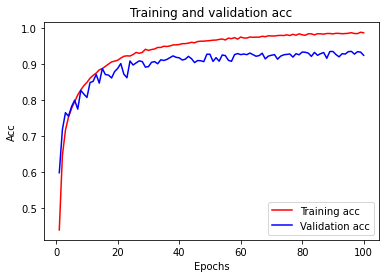

In [7]:
model_cnn.save('/content/drive/MyDrive/CNN_layer_3_location.h5')
model_cnn.evaluate(x_valid, y_valid)

# 3층 1D convnet with location
# accuracy: 0.9250
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [8]:
# CRNN with location
from keras import regularizers
from keras.backend import dropout
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model_crnn = Sequential()
model_crnn.add(layers.Conv1D(64, 5, activation='relu',
                        input_shape=((x_train.shape[1:]))))
model_crnn.add(layers.MaxPooling1D(3))
model_crnn.add(layers.Dropout(0.3))
model_crnn.add(layers.Conv1D(128, 5, activation='relu'))
model_crnn.add(layers.GRU(128))
model_crnn.add(layers.Dense(9, activation='softmax'))

model_crnn.summary()

model_crnn.compile(optimizer='rmsprop',
             loss= 'categorical_crossentropy',
             metrics= ['accuracy'])

history = model_crnn.fit(x_train,
                    y_train,
                    epochs=200,
                    batch_size=2048,
                    validation_data = (x_valid, y_valid))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 496, 64)           4224      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 165, 64)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 165, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 161, 128)          41088     
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                      

376/376 [==============================] - 7s 18ms/step - loss: 0.2402 - accuracy: 0.9485


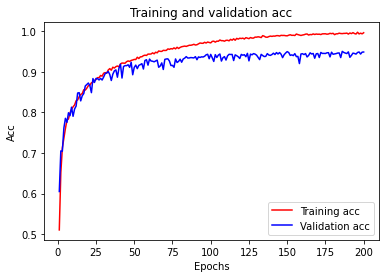

In [9]:
model_crnn.save('/content/drive/MyDrive/CRNN_GRU_location.h5')
model_crnn.evaluate(x_valid, y_valid)

# 랜덤샘플링 CRNN with Location
# accuracy: 0.9485
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [ ]:
# multilayer GRU with Location
from keras import regularizers
from keras.backend import dropout
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(128, input_shape=(500, 13), return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dense(9, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss= 'categorical_crossentropy',
             metrics= ['accuracy'])
model.summary()

history = model.fit(x_train,
                    y_train,
                    epochs=200,
                    batch_size=1024,
                    validation_data = (x_valid, y_valid))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500, 128)          72704     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 9)                 585       
                                                                 
Total params: 122,697
Trainable params: 122,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
47/47 [==============================] - 51s 898ms/step - loss: 1.1492 - accuracy: 0.6121 - val_loss: 0.8504 - val_accuracy: 0.7033
Epoch 2/200
47/47 [==============================] - 41s 867ms/step - loss: 0.7644 - accuracy: 0.7383 - val_loss: 0.6884 - val_accuracy: 0.7638
Epoch 3/200
47/47 [=======

In [ ]:
model.save('/content/drive/MyDrive/multilayer_LSTM_location.h5')
model.evaluate(x_valid, y_valid)

# multilayer LSTM(2) with Location
# accuracy: 0.8610
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()